In [1]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
import random
from shapely.geometry import Point
from tqdm import tqdm
import os
import glob
from scipy.stats import ks_2samp
import geopandas as gpd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, chisquare

C:\Users\pamelama\AppData\Local\ESRI\conda\envs\geopython\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## FINAL VALUES AT POINT LOCATION

#### slope_length was added later, then I used the same points with the other variables already included with their values ( "soil_texture","flow_accum","flow_length","slope","ls_factor","buffer_width") because the sample was already representative then I used the same points. I only extracted the values for the new variable slope_length.

In [71]:
# Inputs 
points_path = "final_points_1.gpkg"
base_path = r"Z:\pamela\nomograph\soil_prep"

# Column name
out_col = "slope_length"

# Load all points
gdf = gpd.read_file(points_path)

def sample_raster_at_points(gdf_points, raster_fp, out_colname):
    with rasterio.open(raster_fp) as src:
        gdf_pts = gdf_points.to_crs(src.crs)
        b = src.bounds
        nodata = src.nodata

        def in_bounds(x, y, bnds):
            return (bnds.left <= x <= bnds.right) and (bnds.bottom <= y <= bnds.top)

        values = []
        for pt in gdf_pts.geometry:
            x, y = pt.x, pt.y
            if not in_bounds(x, y, b):
                values.append(np.nan)
                continue
            try:
                val = next(src.sample([(x, y)], indexes=1))
                v = float(val[0])
                if nodata is not None and np.isfinite(nodata) and np.isclose(v, nodata):
                    v = np.nan
                values.append(v)
            except Exception:
                values.append(np.nan)

    return values

# Loop through all zones
all_values = [np.nan] * len(gdf)  # start with all NaN

for zone_id in range(1, 23):  # 1 to 22 inclusive
    raster_path = fr"{base_path}\specific_slopenlength_default_pzone_{zone_id}.tif"
    if not os.path.exists(raster_path):
        print(f"Raster not found: {raster_path}")
        continue

    print(f"Processing zone {zone_id} ...")
    zone_values = sample_raster_at_points(gdf, raster_path, out_col)

    # If a point has NaN, replace it with this zone’s value (if valid)
    for i, v in enumerate(zone_values):
        if np.isnan(all_values[i]) and not np.isnan(v):
            all_values[i] = v

# Add values to GeoDataFrame
gdf[out_col] = all_values

# Save CLEAN (sin NaN) 
gdf_clean = gdf.dropna(subset=[out_col]).copy()
out_path_clean = os.path.splitext(points_path)[0] + f"_with_{out_col}_clean.gpkg"
gdf_clean.to_file(out_path_clean, driver="GPKG")
print(f"[CLEAN] Guardado: {out_path_clean}")

print(f"Done. Added column '{out_col}' with values from all 22 zones.")
print(gdf[[out_col]].describe())

Processing zone 1 ...
Processing zone 2 ...
Processing zone 3 ...
Processing zone 4 ...
Processing zone 5 ...
Processing zone 6 ...
Processing zone 7 ...
Processing zone 8 ...
Processing zone 9 ...
Processing zone 10 ...
Processing zone 11 ...
Processing zone 12 ...
Processing zone 13 ...
Processing zone 14 ...
Processing zone 15 ...
Processing zone 16 ...
Processing zone 17 ...
Processing zone 18 ...
Processing zone 19 ...
Processing zone 20 ...
Processing zone 21 ...
Processing zone 22 ...
[FULL] Guardado: final_points_1_with_slope_length.gpkg
[CLEAN] Guardado: final_points_1_with_slope_length_clean.gpkg
Done. Added column 'slope_length' with values from all 22 zones.
       slope_length
count  10000.000000
mean     159.259391
std      229.316825
min        0.000000
25%       33.981490
50%       80.409363
75%      187.727345
max     3334.337891


## SECOND SECTION 

## Function for random points generation for sample

In [68]:
# Paths
base_path = r"Z:\pamela\nomograph\soil_prep"
buffer_path = r"Z:\pamela\nomograph\test\v4"
output_path = r"Z:\pamela\nomograph\output_sample"

# Raster file patterns 
layers = {
    "soil_texture": fr"{base_path}\estsoil_labeled_pzone_{{}}.tif",
    "flow_accum": fr"{base_path}\flowacc_5m_pzone_{{}}.tif",
    "flow_length": fr"{base_path}\flowlength_5m_pzone_{{}}.tif",
    "slope": fr"{base_path}\slope_5m_pzone_{{}}.tif",
    "ls_factor": fr"{base_path}\ls_faktor5m_pzone_{{}}.tif",
    "slope_length": fr"{base_path}\specific_slopenlength_default_pzone_{{}}.tif",
    "buffer_width": fr"{buffer_path}\buffer_size_with_log_pzone_{{}}.tif",
}

#ls_faktor5m_pzone_1_cog=ls_faktor5m_pzone_1 (I renamed all)

In [49]:
# Number of valid samples to collect
TARGET_POINTS = 10000

def sample_random_points_from_raster(raster_path, num_points):
    with rasterio.open(raster_path) as src:
        raster_data=src.read(1)
        bounds = src.bounds
        points = []
        for _ in range(num_points * 5):  # generate extra to filter later
            x = random.uniform(bounds.left, bounds.right)
            y = random.uniform(bounds.bottom, bounds.top)
            row, col = src.index(x, y)
            value = raster_data[row, col]
            if not np.isnan(value) and value != src.nodata:
                points.append(Point(x, y))
            if len(points) >= num_points:
                break
        return gpd.GeoDataFrame(geometry=points, crs=src.crs)

def extract_raster_values(point_gdf, raster_path, column_name):
    values = []
    with rasterio.open(raster_path) as src:
        data_extraction=src.read(1)
        value_nodata=src.nodata
        print(f"Set {value_nodata} as no data value for {raster_path}")
        for point in point_gdf.geometry:
            row, col = src.index(point.x, point.y)
            value = data_extraction[row, col]
            if value == value_nodata:
                values.append(np.nan)
            else:
                values.append(value)
    point_gdf[column_name] = values
    return point_gdf

In [50]:
def sample_valid_points_across_layers(layers_dict, zone_id, num_points, max_attempts=5000):
    """
    Samples points that have valid data across ALL specified layers for a given zone.
    
    Args:
        layers_dict: Dictionary of layer patterns (your 'layers' variable)
        zone_id: Zone ID to sample from
        num_points: Desired number of valid points
        max_attempts: Maximum random points to try before giving up
        
    Returns:
        GeoDataFrame with valid points and all layer values
    """
    # Open all rasters for this zone first
    rasters = {}
    for name, pattern in layers_dict.items():
        path = pattern.format(zone_id)
        try:
            rasters[name] = {
                'src': rasterio.open(path),
                'data': None,  # We'll read bands as needed
                'nodata': rasterio.open(path).nodata
            }
        except Exception as e:
            print(f"Failed to open {name} for zone {zone_id}: {e}")
            return None
    
    points = []
    values = {name: [] for name in layers_dict.keys()}
    
    # Get combined bounds (smallest common area)
    bounds_list = [r['src'].bounds for r in rasters.values()]
    left = max(b.left for b in bounds_list)
    right = min(b.right for b in bounds_list)
    bottom = max(b.bottom for b in bounds_list)
    top = min(b.top for b in bounds_list)
    
    attempts = 0
    while len(points) < num_points and attempts < max_attempts:
        attempts += 1
        
        # Generate random point within common bounds
        x = random.uniform(left, right)
        y = random.uniform(bottom, top)
        
        valid = True
        point_values = {}
        
        # Check all layers for this point
        for name, raster in rasters.items():
            try:
                row, col = raster['src'].index(x, y)
                value = raster['src'].read(1, window=((row, row+1), (col, col+1)))[0,0]  # Fixed parenthesis here
                
                if np.isnan(value) or (raster['nodata'] is not None and value == raster['nodata']):
                    valid = False
                    break
                    
                point_values[name] = value
                
            except (IndexError, rasterio.errors.RasterioError):
                valid = False
                break
        
        if valid:
            points.append(Point(x, y))
            for name, val in point_values.items():
                values[name].append(val)
    
    # Close all rasters
    for raster in rasters.values():
        raster['src'].close()
    
    if len(points) < num_points:
        print(f"Warning: Only found {len(points)} valid points out of {num_points} for zone {zone_id}")
    
    # Create GeoDataFrame with all values
    gdf = gpd.GeoDataFrame(geometry=points, crs=rasters[list(rasters.keys())[0]]['src'].crs)
    for name in layers_dict.keys():
        gdf[name] = values[name]
    
    return gdf

In [51]:
# Collect valid samples from all zones
all_points = []
for zone_id in range(1, 23):
    print(f"Processing zone {zone_id}...")
    soil_raster = layers["soil_texture"].format(zone_id)
    buffer_raster = layers["buffer_width"].format(zone_id)
    # Generate ~700 points per zone-tile
    points = sample_random_points_from_raster(soil_raster, 700)
    points = sample_valid_points_across_layers(layers, zone_id, num_points=700)
    print(f"Finish points generated for zone {zone_id} size {len(points)}")
    # Extract all raster values
    df = extract_raster_values(points.copy(), soil_raster, "soil_texture")
    df = extract_raster_values(df, layers["flow_accum"].format(zone_id), "flow_accum")
    df = extract_raster_values(df, layers["flow_length"].format(zone_id), "flow_length")
    df = extract_raster_values(df, layers["slope"].format(zone_id), "slope")
    df = extract_raster_values(df, layers["ls_factor"].format(zone_id), "ls_factor")
    df = extract_raster_values(df, buffer_raster, "buffer_width")
    # Before dropping NaN
    print(f"Total rows in df (BEFORE dropna()): {len(df)} for zone {zone_id}") 
    # Filter valid (no NaN values)
    df = df.dropna()
    # After dropping NaN
    print(f"Rows remaining after dropna(): {len(df)} for zone {zone_id}")
    all_points.append(df)

    # Stop if we have enough #esto comente xq no es necesario, mejor trabajo con todas q es 600 x los 21 tiles
    #if pd.concat(all_points).shape[0] >= TARGET_POINTS:
        #break
# Concatenate
full_df = pd.concat(all_points).reset_index(drop=True)

##la tercera linea , entiendo que los random points son generados en base a los tiles de soil y buffer, xq solo d esos dos? XQ no ncesito de mas incluso puede ser de 1 variable , es espacio es lo mismo 

Processing zone 1...
Finish points generated for zone 1 size 1323
Set 0.0 as no data value for Z:\pamela\nomograph\soil_prep\estsoil_labeled_pzone_1.tif
Set None as no data value for Z:\pamela\nomograph\soil_prep\flowacc_5m_pzone_1.tif
Set None as no data value for Z:\pamela\nomograph\soil_prep\flowlength_5m_pzone_1.tif
Set -9999.0 as no data value for Z:\pamela\nomograph\soil_prep\slope_5m_pzone_1.tif
Set -3.4028230607370965e+38 as no data value for Z:\pamela\nomograph\soil_prep\ls_faktor5m_pzone_1.tif
Set -1.0 as no data value for Z:\pamela\nomograph\test\v4\buffer_size_with_log_pzone_1.tif
Total rows in df (BEFORE dropna()): 1323 for zone 1
Rows remaining after dropna(): 1323 for zone 1
Processing zone 2...
Finish points generated for zone 2 size 1219
Set 0.0 as no data value for Z:\pamela\nomograph\soil_prep\estsoil_labeled_pzone_2.tif
Set None as no data value for Z:\pamela\nomograph\soil_prep\flowacc_5m_pzone_2.tif
Set None as no data value for Z:\pamela\nomograph\soil_prep\flowl

In [55]:
# Mapping: column name → a representative raster file (zone 1 is enough)
column_raster_map = {
    "soil_texture": r"Z:\pamela\nomograph\soil_prep\estsoil_labeled_pzone_1.tif",
    "flow_accum": r"Z:\pamela\nomograph\soil_prep\flowacc_5m_pzone_1.tif",
    "flow_length": r"Z:\pamela\nomograph\soil_prep\flowlength_5m_pzone_1.tif",
    "slope": r"Z:\pamela\nomograph\soil_prep\slope_5m_pzone_1.tif",
    "ls_factor": r"Z:\pamela\nomograph\soil_prep\ls_faktor5m_pzone_1.tif",
    "buffer_width": r"Z:\pamela\nomograph\test\v4\buffer_size_with_log_1.tif"
}
# Go through each column and apply NoData replacement
for column, raster_path in column_raster_map.items():
    if column not in full_df.columns:
        print(f"Skipping {column}: not in DataFrame")
        continue

    try:
        with rasterio.open(raster_path) as src:
            nodata = src.nodata

            if nodata is not None:
                print(f"[{column}] Replacing NoData value {nodata} with NaN...")
                mask = full_df[column] == nodata
                full_df.loc[mask, column] = np.nan
                print(f"  → Replaced {mask.sum()} values")
            else:
                print(f"[{column}] No NoData value defined in raster — nothing replaced.")

    except Exception as e:
        print(f"Error opening raster for {column}: {e}")

#Count Data Points in full_df and final_df
# Before dropping NaN
print(f"Total rows in full_df (BEFORE dropna()): {len(full_df)}") 

# Drops rows with any NaN
full_df= full_df.dropna()

# After dropping NaN
print(f"Rows remaining after dropna(): {len(full_df)}")
#print(f"Percentage of data lost: {(1 - len(full_df)/len(full_df_before))*100:.2f}%")


#before aqui analiza mi poblacion
#Antes de tomar la muestra y con nan dropiados
print("Estadísticos de la POBLACIÓN COMPLETA:")
print(full_df.describe())

##sampling
final_df = full_df.sample(n=TARGET_POINTS, random_state=42).reset_index(drop=True)

#after aqui analiza mi sample haber si es representativa
print("\nEstadísticos de la MUESTRA (10,000 puntos):")
print(final_df.describe())

[soil_texture] Replacing NoData value 0.0 with NaN...
  → Replaced 0 values
[flow_accum] No NoData value defined in raster — nothing replaced.
[flow_length] No NoData value defined in raster — nothing replaced.
[slope] Replacing NoData value -9999.0 with NaN...
  → Replaced 0 values
[ls_factor] Replacing NoData value -3.4028230607370965e+38 with NaN...
  → Replaced 0 values
Error opening raster for buffer_width: Z:/pamela/nomograph/test/v4/buffer_size_with_log_1.tif: No such file or directory
Total rows in full_df (BEFORE dropna()): 62753
Rows remaining after dropna(): 62753

Final dataset size: 62753
Statistics of FINAL DATASET:
       soil_texture    flow_accum   flow_length         slope     ls_factor  \
count  62753.000000  62753.000000  62753.000000  62753.000000  62753.000000   
mean       3.349784      5.230730     30.695429      1.283355      0.191321   
std        2.061391     22.175816     47.003510      2.009233      0.685784   
min        1.000000      0.000000      0.00000

In [ ]:
# Before sampling, check how many rows you have
print(f"Rows available in DF: {len(df)}")
print(f"Rows available in full_df: {len(full_df)}")
print(f"Target sample size: {TARGET_POINTS}")

# Adjust sample size if needed
sample_size = min(TARGET_POINTS, len(full_df))
final_df = full_df.sample(n=sample_size, random_state=42).reset_index(drop=True)
print(f"\nFinal sample size: {len(final_df)}")

In [ ]:
## save the final df with the 10000 points

In [ ]:
# Save as CSV and geopackage
final_df.to_csv("final_points.csv", index=False)
print(" Saved as CSV: final_points.csv")

# Save as GeoPackage
if isinstance(final_df, gpd.GeoDataFrame):
    final_df.to_file("final_points.gpkg", driver="GPKG")
    print("Saved as GeoPackage: final_points.gpkg")
else:
    print("final_df has no geometry, only CSV was saved.")

#Evelyn_Uuemaa: Folder to save all the outputs #Z:\landscape_geoinfo\2020_KIK\uncertainty_analysis

## STATISTICAL analysis for 4 groups of random points generated in different run

### points 1 (10000)

Summary statistics of the sample
       soil_texture    flow_accum   flow_length         slope     ls_factor  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       3.597200      4.940600     28.424710      1.340683      0.210158   
std        2.106038     26.776396     41.123484      2.242984      0.919517   
min        1.000000      0.000000      0.000000      0.002668      0.000000   
25%        1.000000      0.000000      5.722824      0.335221      0.000000   
50%        4.000000      1.000000     14.778117      0.687378      0.071775   
75%        6.000000      4.000000     33.413938      1.407015      0.181071   
max        7.000000   1840.000000    558.258118     35.151031     40.955238   

       buffer_width  
count  10000.000000  
mean       6.073391  
std        6.980791  
min        0.000000  
25%        2.402646  
50%        4.382015  
75%        7.482552  
max      107.121277  


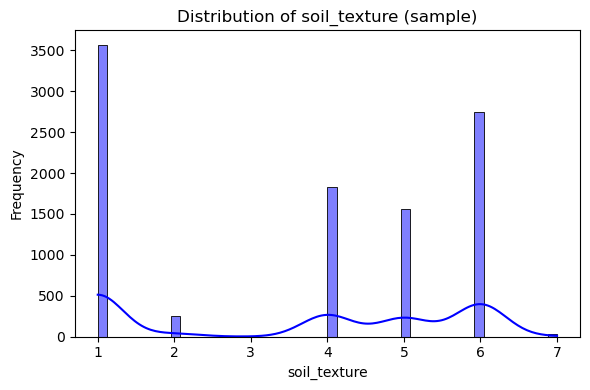

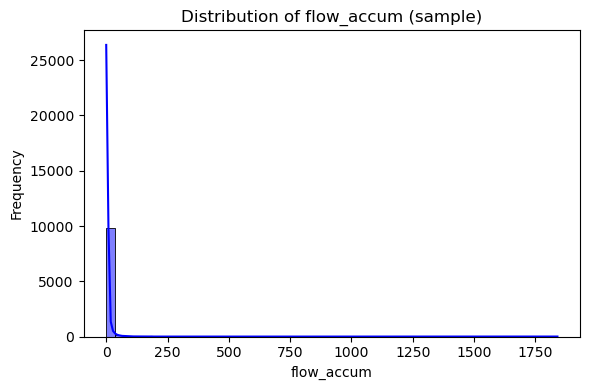

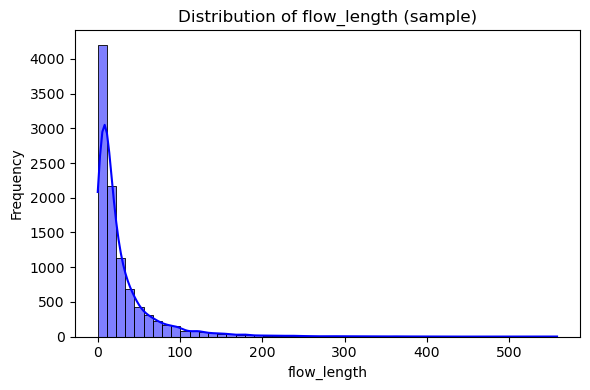

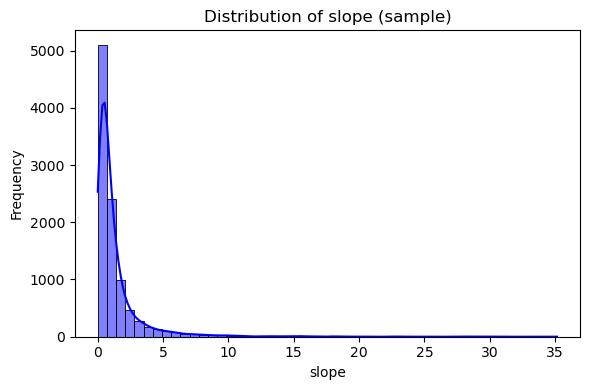

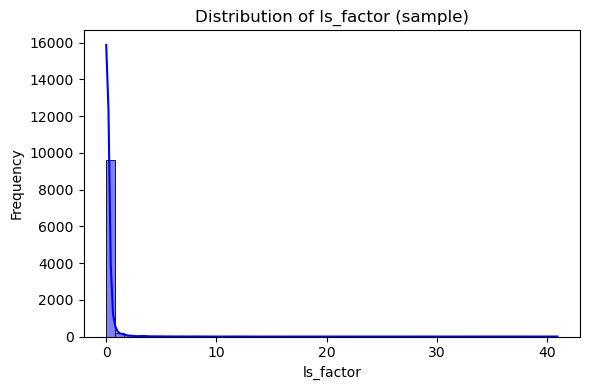

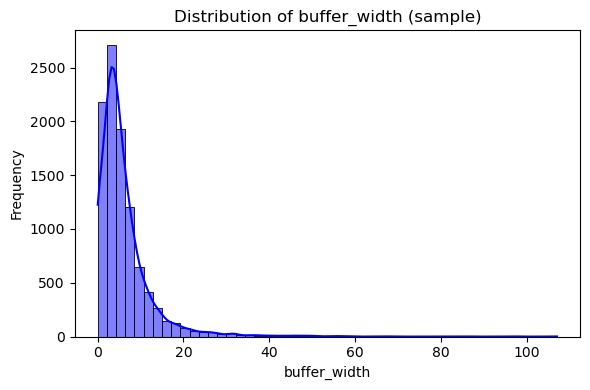

In [23]:
final_df_1 = gpd.read_file("final_points_1.gpkg")
print("Summary statistics of the sample")
print(final_df_1.describe())

# Variables to check (make sure the column names match your file)
variables = ['soil_texture', 'flow_accum', 'flow_length', 'slope', 'ls_factor', 'buffer_width']

# Plot distributions
for var in variables:
    if var in final_df_1.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(final_df_1[var], kde=True, bins=50, color='blue')
        plt.title(f"Distribution of {var} (sample)")
        plt.xlabel(var)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    else:
        print(f" Column '{var}' not found in data.")


### points 2

Summary statistics of the sample
       soil_texture    flow_accum   flow_length         slope     ls_factor  \
count   10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean        3.64370      5.279100     29.125437      1.355063      0.205106   
std         2.10694     22.578569     41.245422      2.161262      0.763287   
min         1.00000      0.000000      0.000000      0.001667      0.000000   
25%         1.00000      0.000000      5.916032      0.335188      0.000000   
50%         4.00000      2.000000     15.144017      0.700109      0.073583   
75%         6.00000      4.000000     34.627220      1.465347      0.185246   
max         7.00000   1083.000000    652.995422     46.785015     38.123863   

       buffer_width  
count  10000.000000  
mean       6.171905  
std        6.954345  
min        0.000000  
25%        2.425786  
50%        4.470852  
75%        7.606567  
max      106.191498  


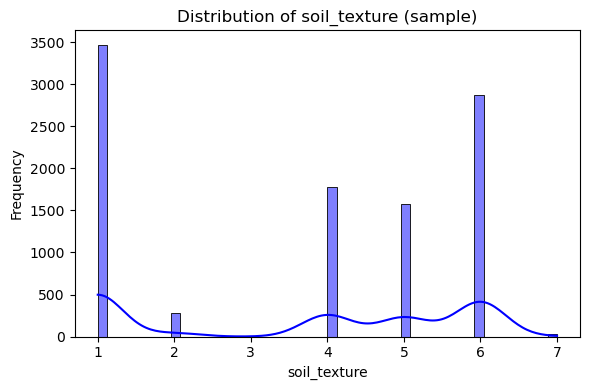

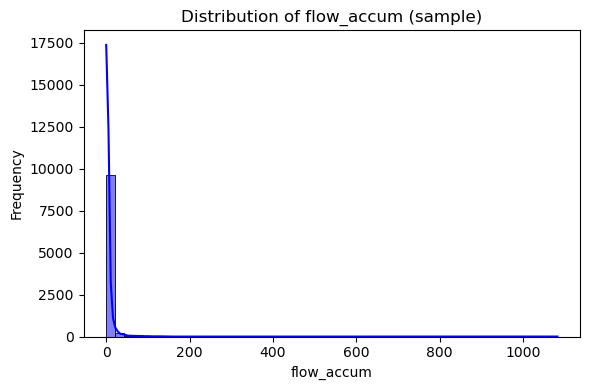

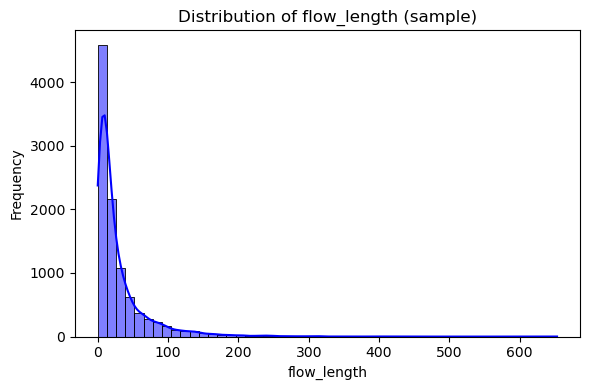

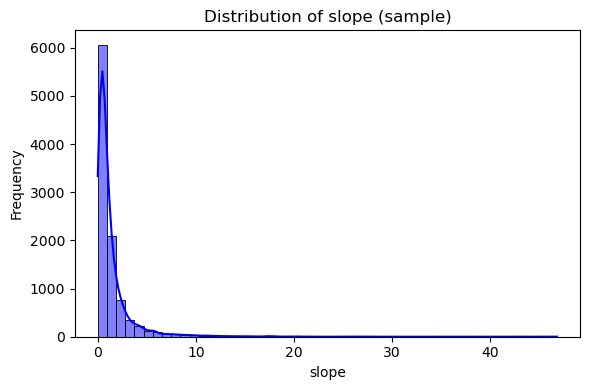

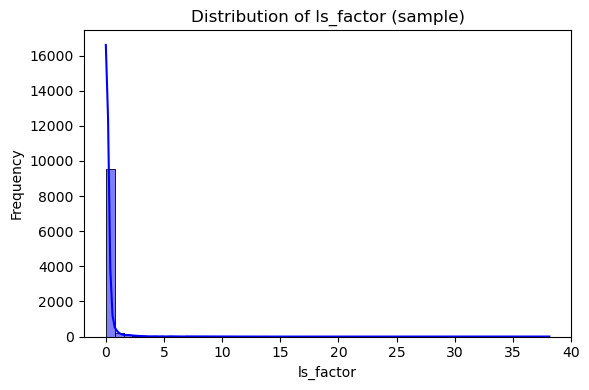

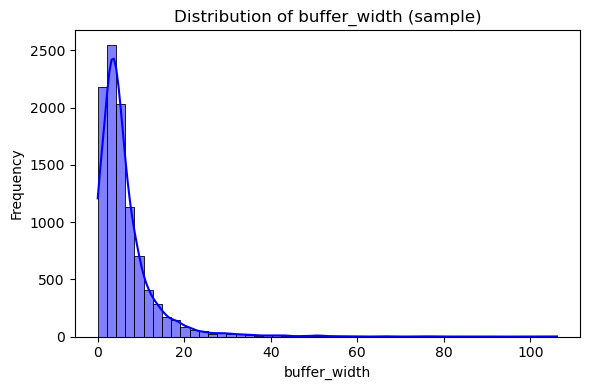

In [24]:
final_df_2 = gpd.read_file("final_points_2.gpkg")
print("Summary statistics of the sample")
print(final_df_2.describe())

# Variables to check (make sure the column names match your file)
variables = ['soil_texture', 'flow_accum', 'flow_length', 'slope', 'ls_factor', 'buffer_width']

# Plot distributions
for var in variables:
    if var in final_df_2.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(final_df_2[var], kde=True, bins=50, color='blue')
        plt.title(f"Distribution of {var} (sample)")
        plt.xlabel(var)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    else:
        print(f" Column '{var}' not found in data.")

### points 3

Summary statistics of the sample
       soil_texture   flow_accum   flow_length         slope     ls_factor  \
count   10000.00000  10000.00000  10000.000000  10000.000000  10000.000000   
mean        3.61070      5.11660     29.993383      1.364640      0.210279   
std         2.10328     21.64835     44.707790      2.245482      0.746886   
min         1.00000      0.00000      0.000000      0.000000      0.000000   
25%         1.00000      0.00000      5.802076      0.333802      0.000000   
50%         4.00000      2.00000     15.313791      0.683469      0.069904   
75%         6.00000      4.00000     34.583712      1.446374      0.185182   
max         7.00000    751.00000    582.256958     38.784523     25.630171   

       buffer_width  
count  10000.000000  
mean       6.239660  
std        7.486772  
min        0.000000  
25%        2.421507  
50%        4.455683  
75%        7.676648  
max      161.826599  


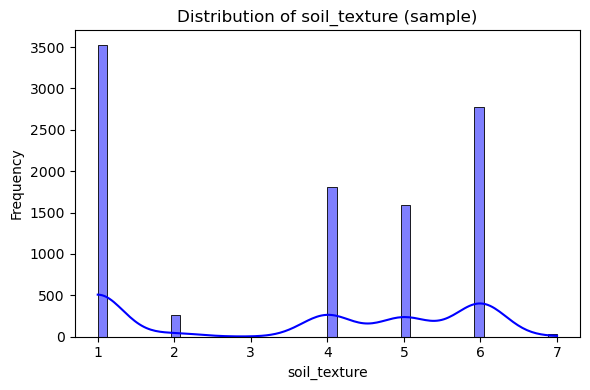

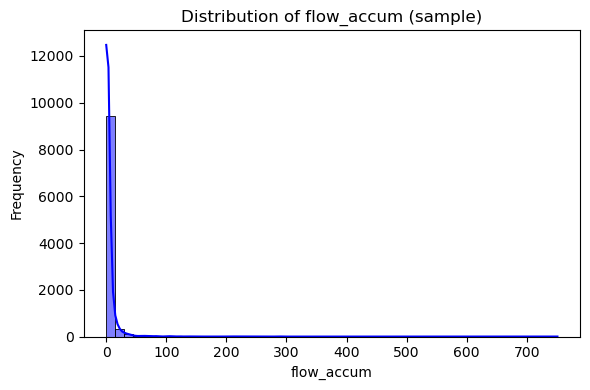

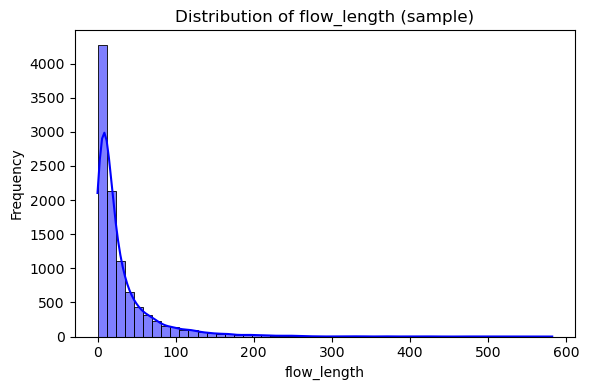

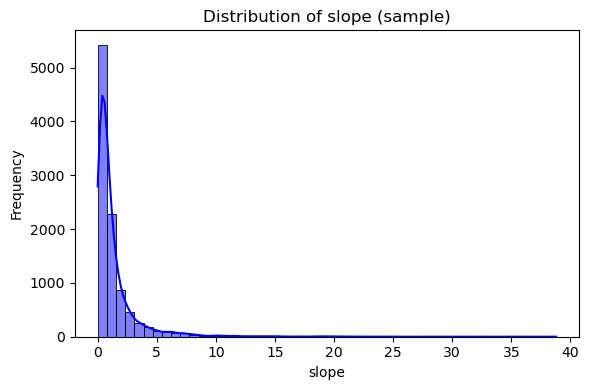

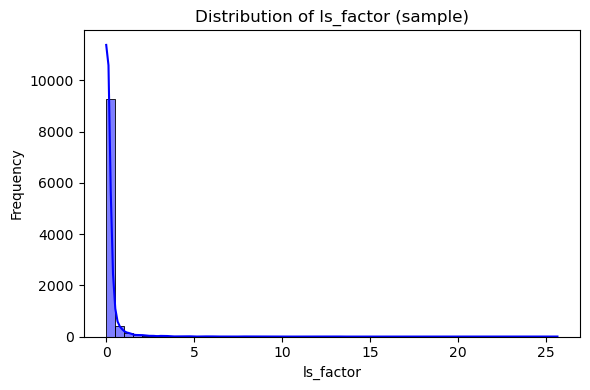

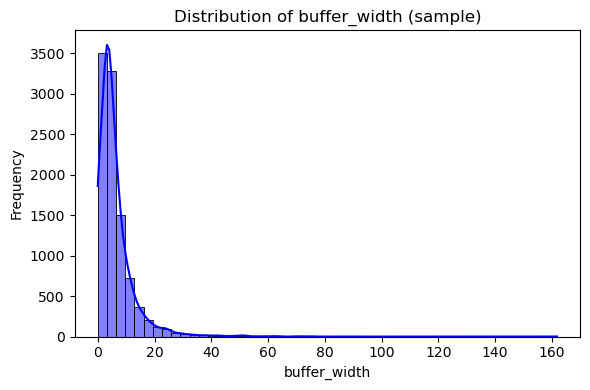

In [35]:
final_df_3 = gpd.read_file("final_points_3.gpkg")
print("Summary statistics of the sample")
print(final_df_3.describe())

# Variables to check (make sure the column names match your file)
variables = ['soil_texture', 'flow_accum', 'flow_length', 'slope', 'ls_factor', 'buffer_width']

# Plot distributions
for var in variables:
    if var in final_df_3.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(final_df_3[var], kde=True, bins=50, color='blue')
        plt.title(f"Distribution of {var} (sample)")
        plt.xlabel(var)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    else:
        print(f" Column '{var}' not found in data.")

### points 4

Summary statistics of the sample
       soil_texture    flow_accum   flow_length         slope    ls_factor  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.00000   
mean       3.647400      4.755800     29.217533      1.361069      0.20638   
std        2.106921     20.494965     42.663614      2.190534      0.79048   
min        1.000000      0.000000      0.000000      0.005272      0.00000   
25%        1.000000      0.000000      5.891848      0.339151      0.00000   
50%        4.000000      1.000000     15.044120      0.704364      0.07235   
75%        6.000000      4.000000     34.303391      1.491304      0.18503   
max        7.000000   1270.000000    736.410706     39.955166     33.72060   

       buffer_width  
count  10000.000000  
mean       6.170047  
std        7.344064  
min        0.000000  
25%        2.384633  
50%        4.446023  
75%        7.582960  
max      177.205566  


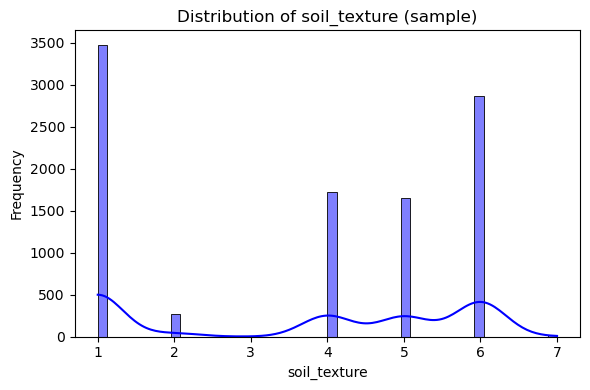

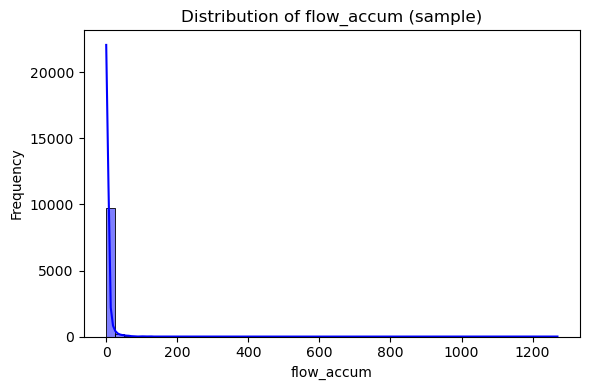

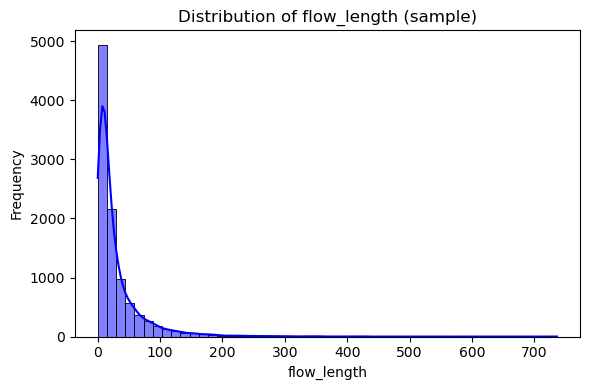

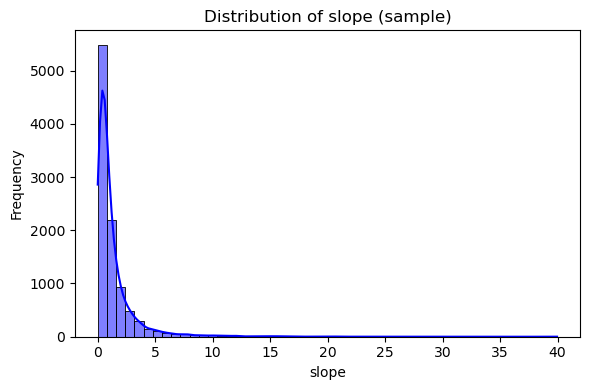

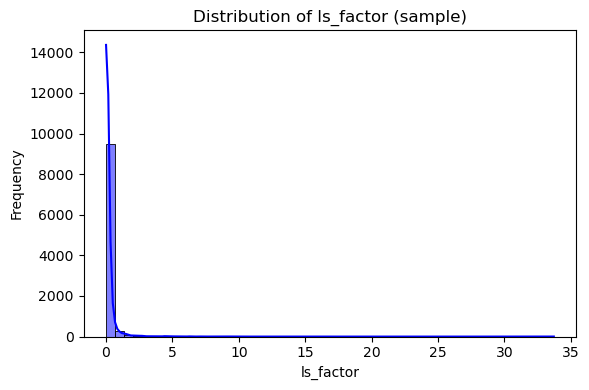

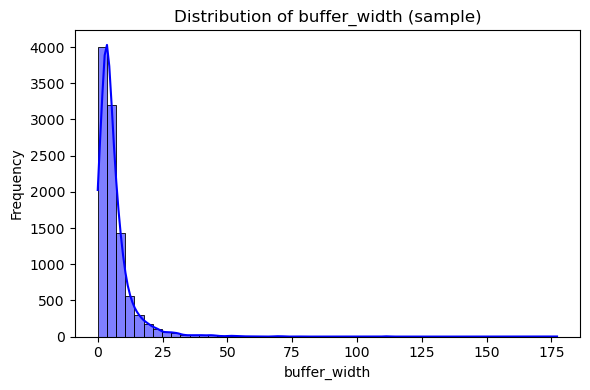

In [36]:
final_df_4 = gpd.read_file("final_points_4.gpkg")
print("Summary statistics of the sample")
print(final_df_4.describe())

# Variables to check (make sure the column names match your file)
variables = ['soil_texture', 'flow_accum', 'flow_length', 'slope', 'ls_factor', 'buffer_width']

# Plot distributions
for var in variables:
    if var in final_df_4.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(final_df_4[var], kde=True, bins=50, color='blue')
        plt.title(f"Distribution of {var} (sample)")
        plt.xlabel(var)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    else:
        print(f" Column '{var}' not found in data.")

### all point data

✅ Loaded final_points_1: final_points_1.gpkg  (10000 rows)
✅ Loaded final_points_2: final_points_2.gpkg  (10000 rows)
✅ Loaded final_points_3: final_points_3.gpkg  (10000 rows)
✅ Loaded final_points_4: final_points_4.gpkg  (10000 rows)

=== Summary statistics across datasets ===
       dataset     variable   count  missing      mean       std      min      25%    median       50%       75%       IQR         max
final_points_1 buffer_width 10000.0        0  6.073391  6.980791 0.000000 2.402646  4.382015  4.382015  7.482552  5.079906  107.121277
final_points_2 buffer_width 10000.0        0  6.171905  6.954345 0.000000 2.425786  4.470852  4.470852  7.606567  5.180781  106.191498
final_points_3 buffer_width 10000.0        0  6.239660  7.486772 0.000000 2.421507  4.455683  4.455683  7.676648  5.255141  161.826599
final_points_4 buffer_width 10000.0        0  6.170047  7.344064 0.000000 2.384633  4.446023  4.446023  7.582960  5.198327  177.205566
final_points_1   flow_accum 10000.0        0 

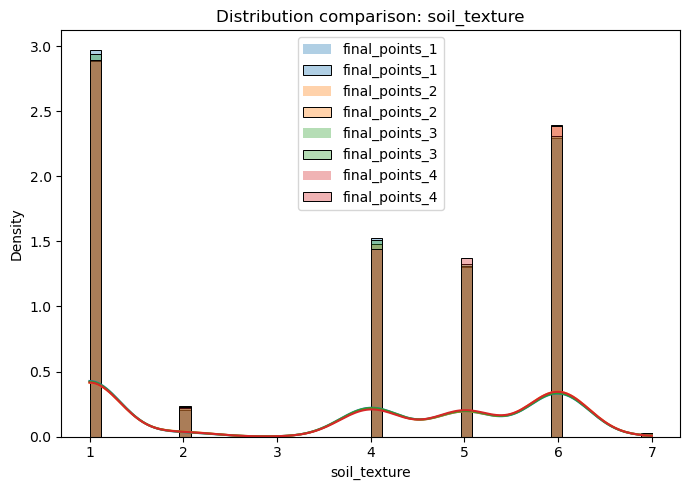

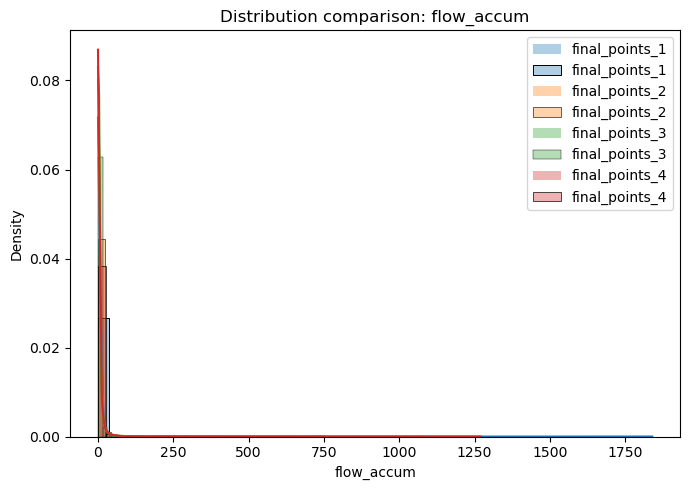

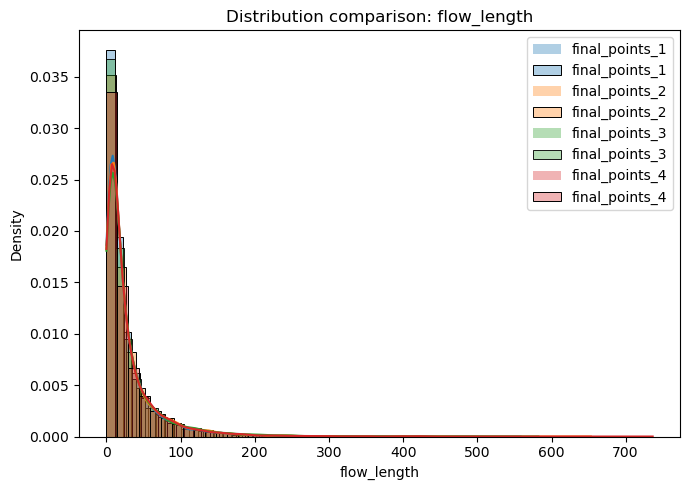

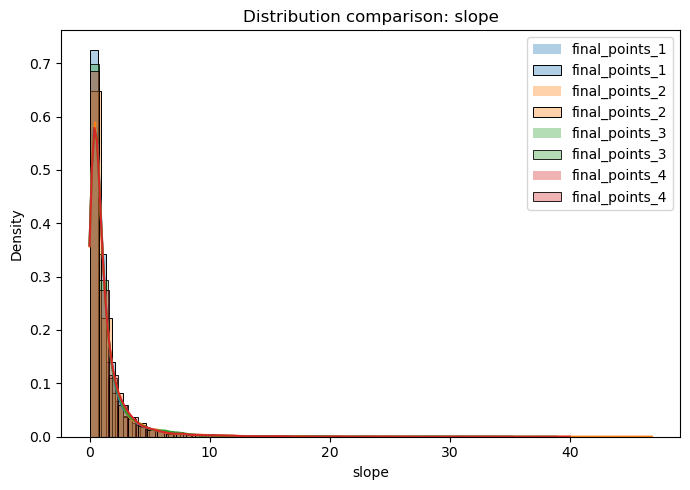

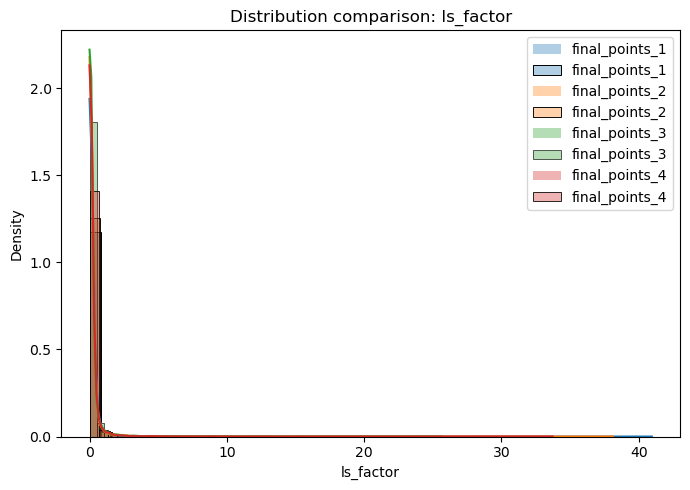

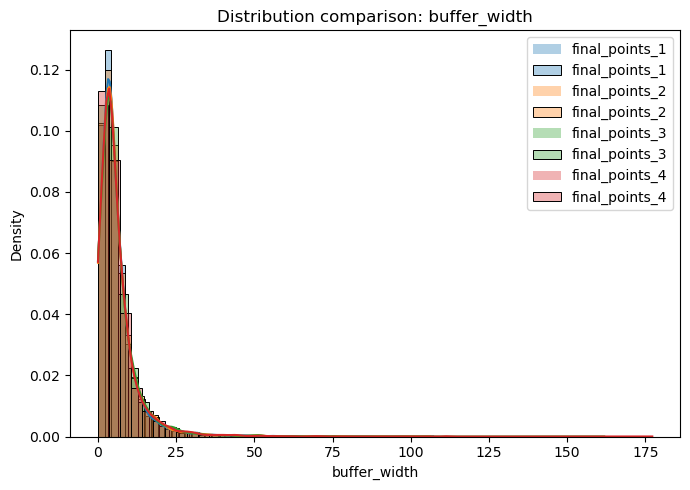

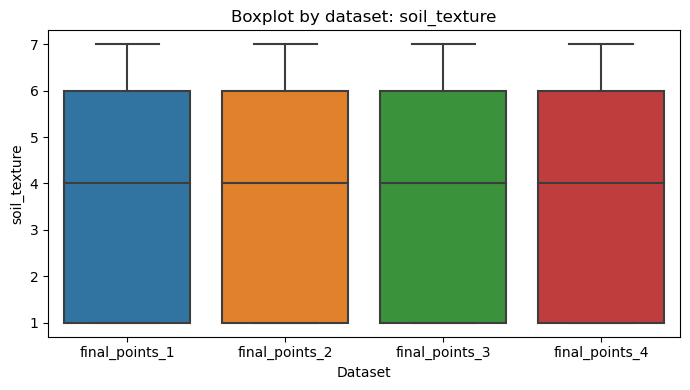

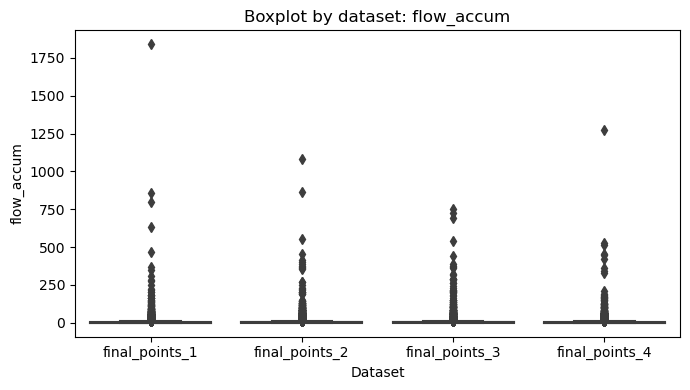

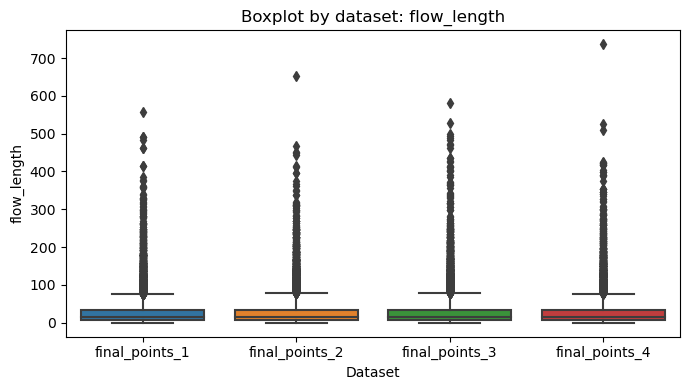

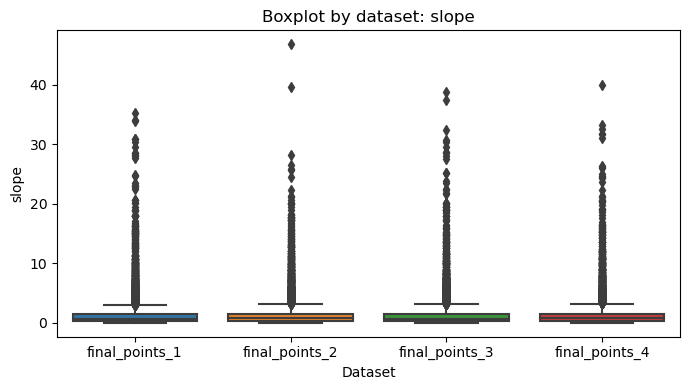

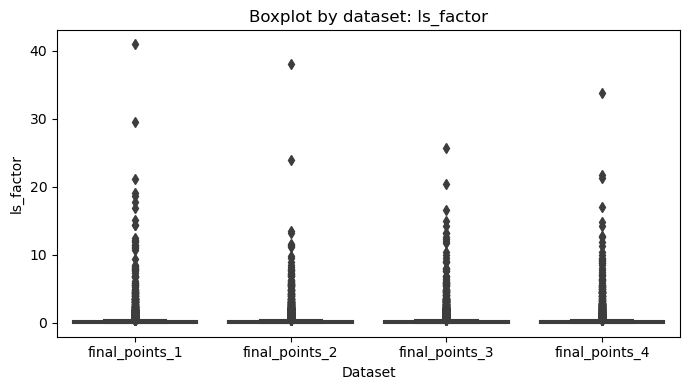

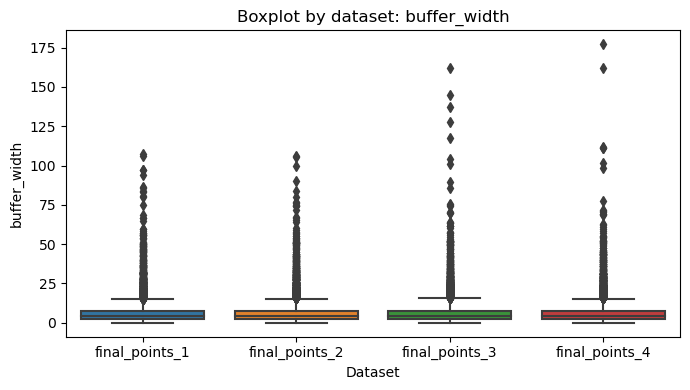

In [34]:
# -----------------------------
# Config
# -----------------------------
files = {
    "final_points_1": "final_points_1.gpkg",
    "final_points_2": "final_points_2.gpkg",
    "final_points_3": "final_points_3.gpkg",
    "final_points_4": "final_points_4.gpkg",
}

# Variables to compare (edit to match your columns)
variables = ['soil_texture', 'flow_accum', 'flow_length', 'slope', 'ls_factor', 'buffer_width']

# -----------------------------
# Load data
# -----------------------------
dfs = {}
for name, path in files.items():
    try:
        df = gpd.read_file(path)
        dfs[name] = df
        print(f"✅ Loaded {name}: {path}  ({len(df)} rows)")
    except Exception as e:
        print(f"❌ Could not load {name} from {path}: {e}")

# -----------------------------
# Check columns and report missing
# -----------------------------
for name, df in dfs.items():
    missing = [v for v in variables if v not in df.columns]
    if missing:
        print(f"⚠️ {name} is missing columns: {missing}")

# -----------------------------
# Build summary stats (side-by-side)
# -----------------------------
def summarize_df(df, dataset_name, cols):
    sub = df[cols].copy()
    desc = sub.describe().T  # count, mean, std, min, 25%, 50%, 75%, max
    desc['median'] = sub.median(numeric_only=True)
    desc['IQR'] = desc['75%'] - desc['25%']
    desc['missing'] = sub.isna().sum()
    desc['dataset'] = dataset_name
    return desc.reset_index().rename(columns={'index': 'variable'})

summary_list = []
for name, df in dfs.items():
    # Only include variables present in this dataset
    present_cols = [v for v in variables if v in df.columns]
    if present_cols:
        summary_list.append(summarize_df(df, name, present_cols))

if summary_list:
    summary_all = pd.concat(summary_list, ignore_index=True)
    # Reorder columns for readability
    cols_order = ['dataset', 'variable', 'count', 'missing', 'mean', 'std', 'min', '25%', 'median', '50%', '75%', 'IQR', 'max']
    summary_all = summary_all[[c for c in cols_order if c in summary_all.columns]]
    print("\n=== Summary statistics across datasets ===")
    print(summary_all.sort_values(['variable', 'dataset']).to_string(index=False))
else:
    print("No summaries to show (no variables found).")

# Optional: save to CSV for later review
# summary_all.to_csv("summary_stats_across_datasets.csv", index=False)

# -----------------------------
# Overlay histograms + KDEs
# -----------------------------
for var in variables:
    # Skip if none of the datasets has this column
    if not any(var in df.columns for df in dfs.values()):
        print(f"⏭️ Skipping {var}: not found in any dataset.")
        continue

    plt.figure(figsize=(7,5))
    for name, df in dfs.items():
        if var in df.columns:
            sns.histplot(df[var].dropna(), kde=True, bins=50, stat='density', alpha=0.35, label=name)
    plt.title(f"Distribution comparison: {var}")
    plt.xlabel(var)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# Boxplots per variable (compare datasets)
# -----------------------------
# Build a long-form DataFrame: variable, value, dataset
long_rows = []
for name, df in dfs.items():
    for var in variables:
        if var in df.columns:
            vals = df[var].dropna().values
            if len(vals) > 0:
                long_rows.append(pd.DataFrame({'variable': var, 'value': vals, 'dataset': name}))

if long_rows:
    long_df = pd.concat(long_rows, ignore_index=True)
    for var in variables:
        sub = long_df[long_df['variable'] == var]
        if sub.empty:
            continue
        plt.figure(figsize=(7,4))
        sns.boxplot(data=sub, x='dataset', y='value')
        plt.title(f"Boxplot by dataset: {var}")
        plt.xlabel("Dataset")
        plt.ylabel(var)
        plt.tight_layout()
        plt.show()
else:
    print("No data available to plot boxplots.")


## "Referal (fake) population" vs sample , representatives is the same?

### What this does:

Summary stats: prints population vs. sample (mean, std, quantiles, max/min, mean error %).

Tests:

Continuous vars → KS test

Soil (ordinal) → Chi-square test

Plots: population vs. sample distributions (KDE curves).

Results table with test statistics and p-values.

If p > 0.05, you cannot reject the null hypothesis → the sample distribution is consistent with the population (representative).

=== Summary Statistics Comparison ===
               mean_pop    std_pop   min_pop   25%_pop    50%_pop    75%_pop  \
soil_texture   3.349784   2.061391  1.000000  1.000000   4.000000   5.000000   
flow_accum     5.230730  22.175816  0.000000  0.000000   2.000000   4.000000   
flow_length   30.695430  47.003508  0.000000  5.873653  15.283978  35.357273   
slope          1.283355   2.009233  0.001215  0.332633   0.680021   1.411249   
ls_factor      0.191321   0.685784  0.000000  0.000000   0.075736   0.188477   
buffer_width   6.316742   6.993032  0.000000  2.666782   4.721787   7.959183   

                  max_pop  mean_final_points_1  std_final_points_1  \
soil_texture     7.000000             3.597200            2.106038   
flow_accum    1233.000000             4.940600           26.776396   
flow_length   1176.934326            28.424710           41.123484   
slope           43.316994             1.340683            2.242984   
ls_factor       51.015324             0.210158     

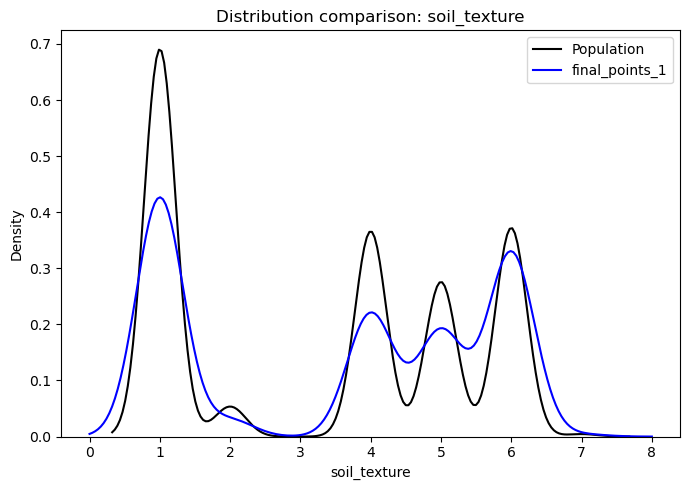

flow_accum: KS = 0.013, p = 0.106


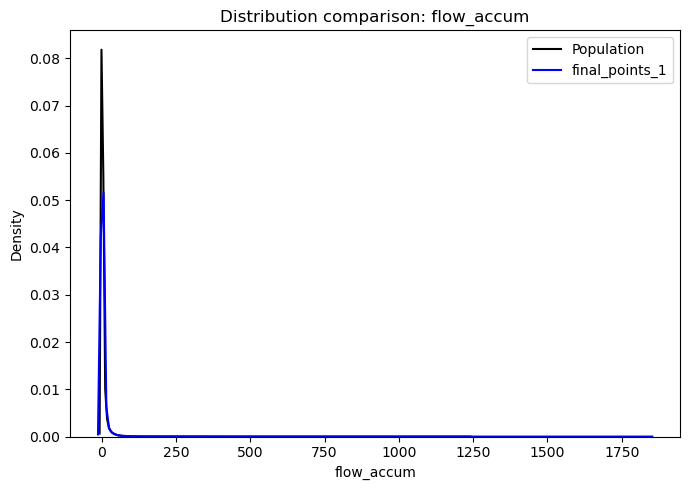

flow_length: KS = 0.017, p = 0.013


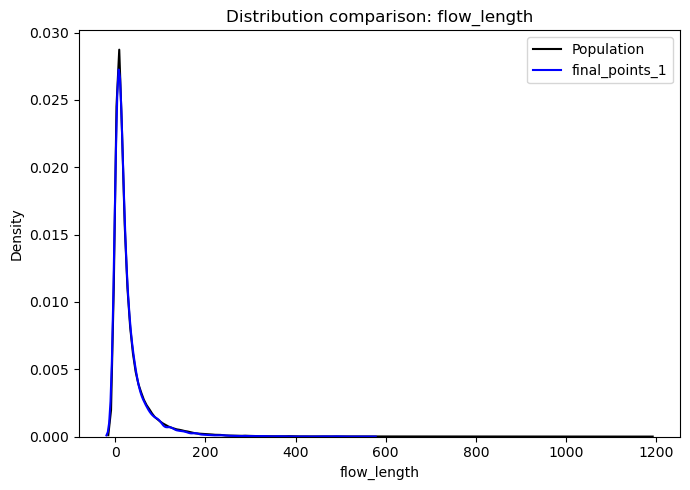

slope: KS = 0.008, p = 0.607


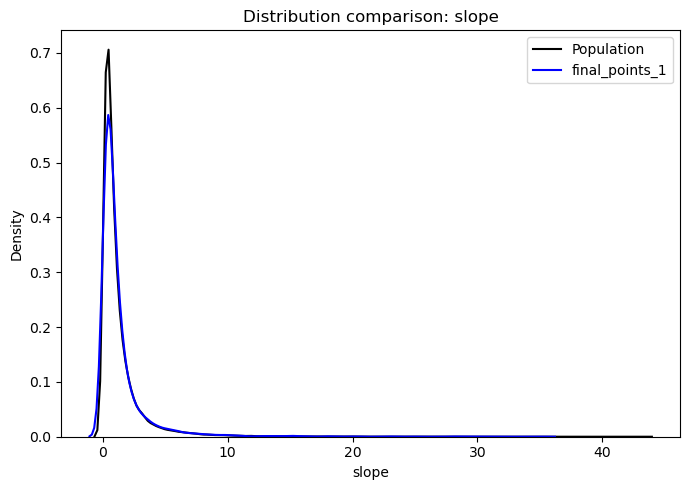

ls_factor: KS = 0.017, p = 0.011


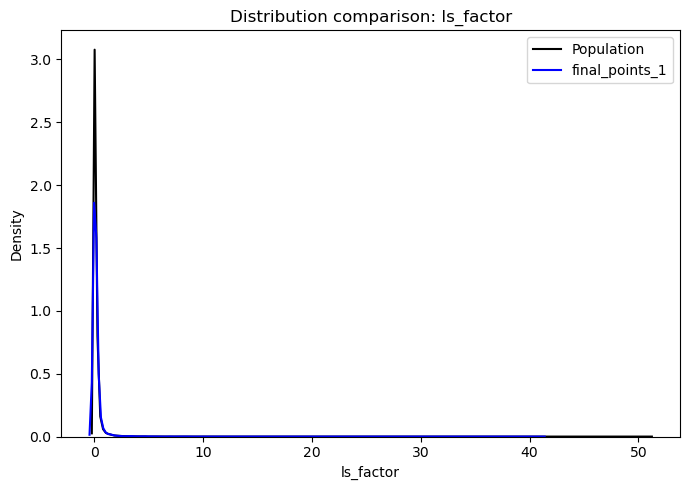

buffer_width: KS = 0.040, p = 0.000


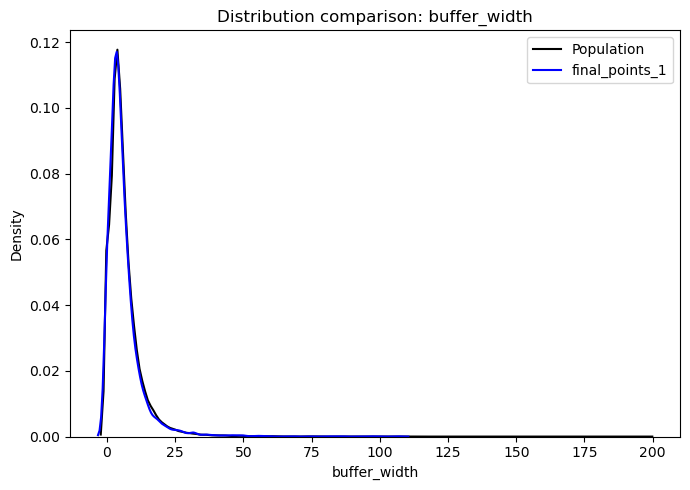


=== Test Results Table ===
       variable  test   statistic       p_value
0  soil_texture  chi2  266.596156  1.506114e-55
1    flow_accum    ks    0.013023  1.063274e-01
2   flow_length    ks    0.017059  1.306142e-02
3         slope    ks    0.008189  6.065564e-01
4     ls_factor    ks    0.017318  1.119425e-02
5  buffer_width    ks    0.040466  1.041995e-12


In [58]:
fake_population_df = gpd.read_file("ref_population.gpkg")
final_points_1 = gpd.read_file("final_points_1.gpkg")

# Variables to check
variables = ['soil_texture', 'flow_accum', 'flow_length', 'slope', 'ls_factor', 'buffer_width']

def check_representativeness(pop_df, sample_df, variables, sample_name="Sample"):
    results = []

    print("=== Summary Statistics Comparison ===")
    pop_stats = pop_df[variables].describe().T
    samp_stats = sample_df[variables].describe().T

    comparison = pop_stats[['mean','std','min','25%','50%','75%','max']].join(
        samp_stats[['mean','std','min','25%','50%','75%','max']], 
        lsuffix='_pop', rsuffix=f'_{sample_name}'
    )
    comparison['mean_error_%'] = 100 * (comparison[f'mean_{sample_name}'] - comparison['mean_pop']) / comparison['mean_pop']
    print(comparison)

    print("\n=== Distribution Tests (KS or Chi-square) ===")
    for var in variables:
        pop_vals = pop_df[var].dropna()
        samp_vals = sample_df[var].dropna()

        if var == 'soil_texture':  # ordinal/discrete
            pop_counts = pop_vals.value_counts(normalize=True).sort_index()
            samp_counts = samp_vals.value_counts(normalize=True).sort_index()
            # align
            all_idx = sorted(set(pop_counts.index) | set(samp_counts.index))
            pop_freq = pop_counts.reindex(all_idx, fill_value=0)
            samp_freq = samp_counts.reindex(all_idx, fill_value=0)
            chi2, p = chisquare(f_obs=samp_freq*len(sample_df), f_exp=pop_freq*len(sample_df))
            print(f"{var}: Chi-square = {chi2:.3f}, p = {p:.3f}")
            results.append((var, 'chi2', chi2, p))
        else:  # continuous
            ks_stat, p = ks_2samp(pop_vals, samp_vals)
            print(f"{var}: KS = {ks_stat:.3f}, p = {p:.3f}")
            results.append((var, 'ks', ks_stat, p))

        # Plot distributions
        plt.figure(figsize=(7,5))
        sns.kdeplot(pop_vals, label='Population', color='black')
        sns.kdeplot(samp_vals, label=sample_name, color='blue')
        plt.title(f"Distribution comparison: {var}")
        plt.xlabel(var)
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results, columns=['variable','test','statistic','p_value'])

# Run the function
representativeness_results = check_representativeness(fake_population_df, final_points_1, variables, sample_name="final_points_1")

print("\n=== Test Results Table ===")
print(representativeness_results)

## FINAL CORRELATION ANALYSIS BW VARIABLES 

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, anderson, skew, kurtosis, probplot

In [4]:
# Load your sample
final_df_1 = gpd.read_file("points_final.gpkg")
# Variables to analyse
variables = ['slope','soil_texture', 'flow_accum', 'ls_factor', 'flow_length','slope_length','buffer_width']

### 1) NORMALITY CHECK (large n) (no needed at all)

=== Normality (large-sample) diagnostics ===
       variable      n   skewness  excess_kurtosis  dagostino_K2  dagostino_p  \
0  soil_texture  10000  -0.209294        -1.646033  46496.013196          0.0   
1    flow_accum  10000  41.380535      2437.614256  29444.799159          0.0   
2   flow_length  10000   3.898085        23.757445   8341.592750          0.0   
3         slope  10000   5.971646        54.015714  11445.456961          0.0   
4     ls_factor  10000  20.262923       618.224786  22092.510628          0.0   
5  slope_length  10000   3.896537        23.926190   8346.669918          0.0   
6  buffer_width  10000   4.586865        37.430355   9620.380234          0.0   

   anderson_stat  anderson_crit_5%          anderson_sig_levels  
0     836.126229             0.787  [15.0, 10.0, 5.0, 2.5, 1.0]  
1    2648.493232             0.787  [15.0, 10.0, 5.0, 2.5, 1.0]  
2    1017.289941             0.787  [15.0, 10.0, 5.0, 2.5, 1.0]  
3    1364.117493             0.787  [15.0,

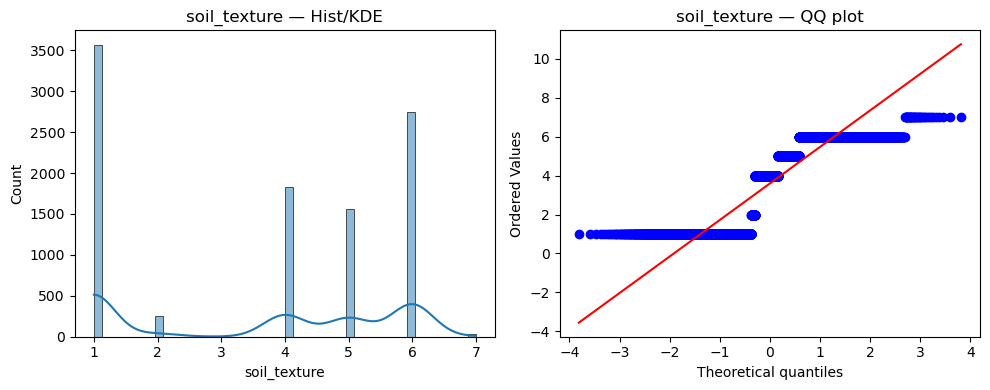

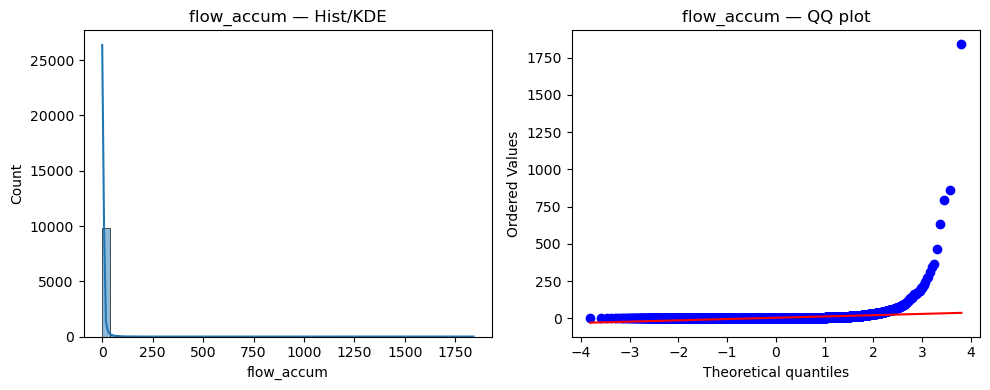

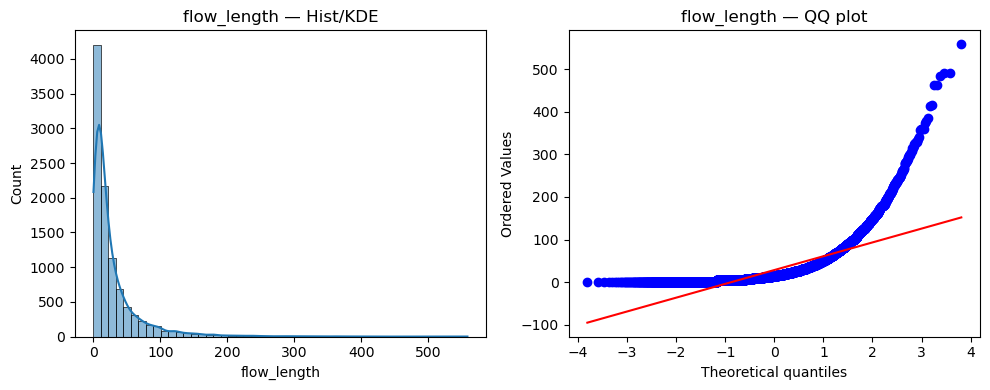

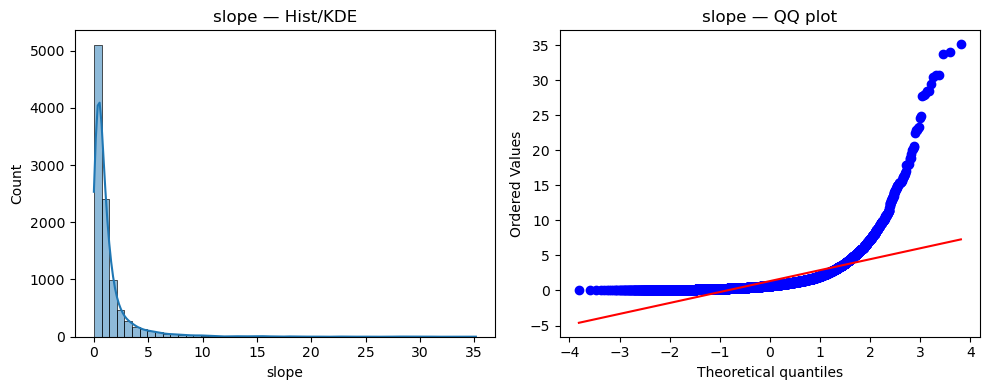

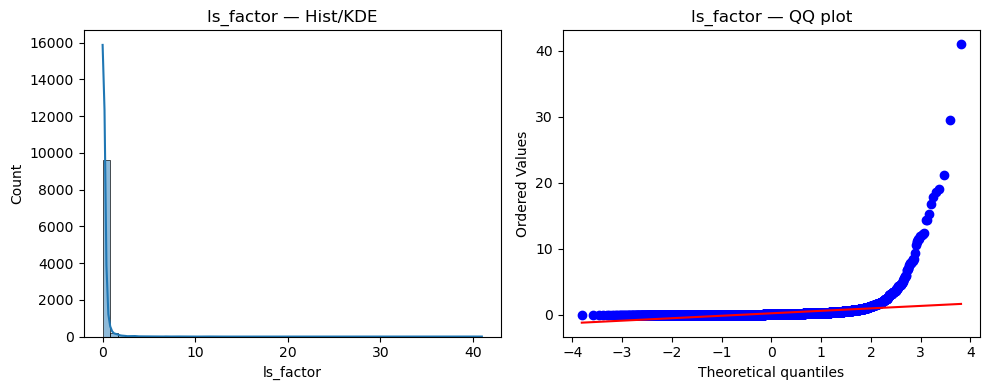

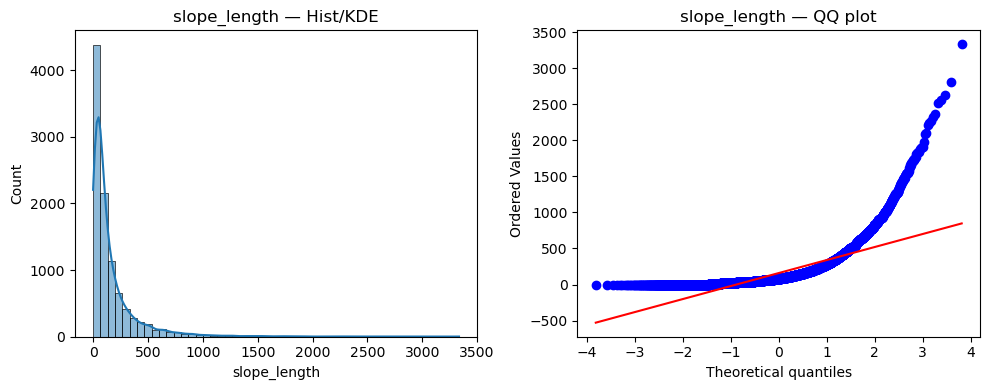

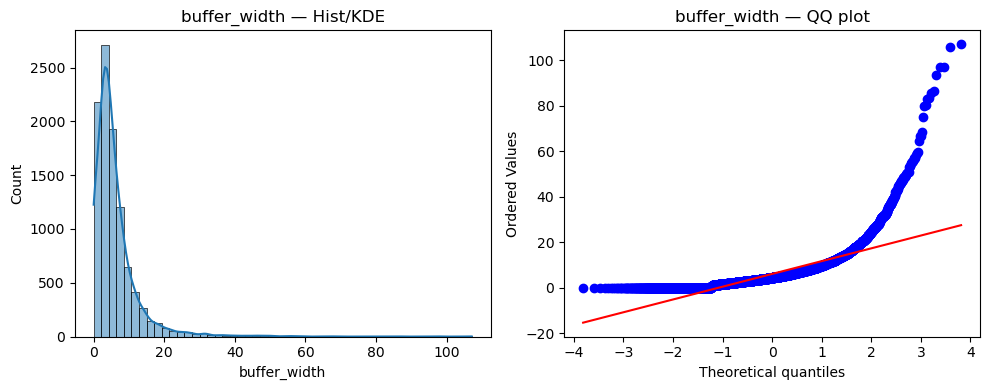

In [76]:
# 1) NORMALITY CHECK (large n)
rows = []
for var in variables:
    x = final_df_1[var].dropna().to_numpy()
    if len(x) < 10:
        continue
    dag_stat, dag_p = normaltest(x)                # D’Agostino’s K²
    ad = anderson(x, dist='norm')                  # Anderson–Darling
    sk = skew(x, bias=False)
    ex_kurt = kurtosis(x, fisher=True, bias=False) # excess kurtosis (0 = normal)

    rows.append({
        'variable': var,
        'n': len(x),
        'skewness': sk,
        'excess_kurtosis': ex_kurt,
        'dagostino_K2': dag_stat,
        'dagostino_p': dag_p,
        'anderson_stat': ad.statistic,
        'anderson_crit_5%': ad.critical_values[2],   # 5% level
        'anderson_sig_levels': ad.significance_level # array for reference
    })

normality_df = pd.DataFrame(rows)
print("=== Normality (large-sample) diagnostics ===")
print(normality_df)

print("\nInterpretation tips:")
print("- Skewness > 0: right-skew; < 0: left-skew.")
print("- Excess kurtosis ≈ 0 for normal; > 0 heavy tails.")
print("- D’Agostino p < 0.05: reject normality.")
print("- Anderson: if statistic > critical (e.g., 5%), reject normality at that level.")

# Optional: quick visuals per variable (hist/KDE + QQ plot)
for var in variables:
    if var not in final_df_1.columns: 
        continue
    x = final_df_1[var].dropna()
    if x.empty: 
        continue

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    sns.histplot(x, bins=50, kde=True, ax=ax[0])
    ax[0].set_title(f"{var} — Hist/KDE")
    ax[0].set_xlabel(var); ax[0].set_ylabel("Count")

    probplot(x, dist="norm", plot=ax[1])
    ax[1].set_title(f"{var} — QQ plot")
    plt.tight_layout(); plt.show()

### 2) CORRELATIONS


=== Spearman correlation matrix ===
                 slope  soil_texture  flow_accum  ls_factor  flow_length  \
slope         1.000000      0.192401    0.166263   0.332799     0.367879   
soil_texture  0.192401      1.000000    0.049306   0.060002     0.085190   
flow_accum    0.166263      0.049306    1.000000   0.544190     0.617818   
ls_factor     0.332799      0.060002    0.544190   1.000000     0.468731   
flow_length   0.367879      0.085190    0.617818   0.468731     1.000000   
slope_length  0.394054      0.088361    0.654873   0.560635     0.987964   
buffer_width  0.529142     -0.334851    0.582793   0.484417     0.748555   

              slope_length  buffer_width  
slope             0.394054      0.529142  
soil_texture      0.088361     -0.334851  
flow_accum        0.654873      0.582793  
ls_factor         0.560635      0.484417  
flow_length       0.987964      0.748555  
slope_length      1.000000      0.770853  
buffer_width      0.770853      1.000000  

=== Pears

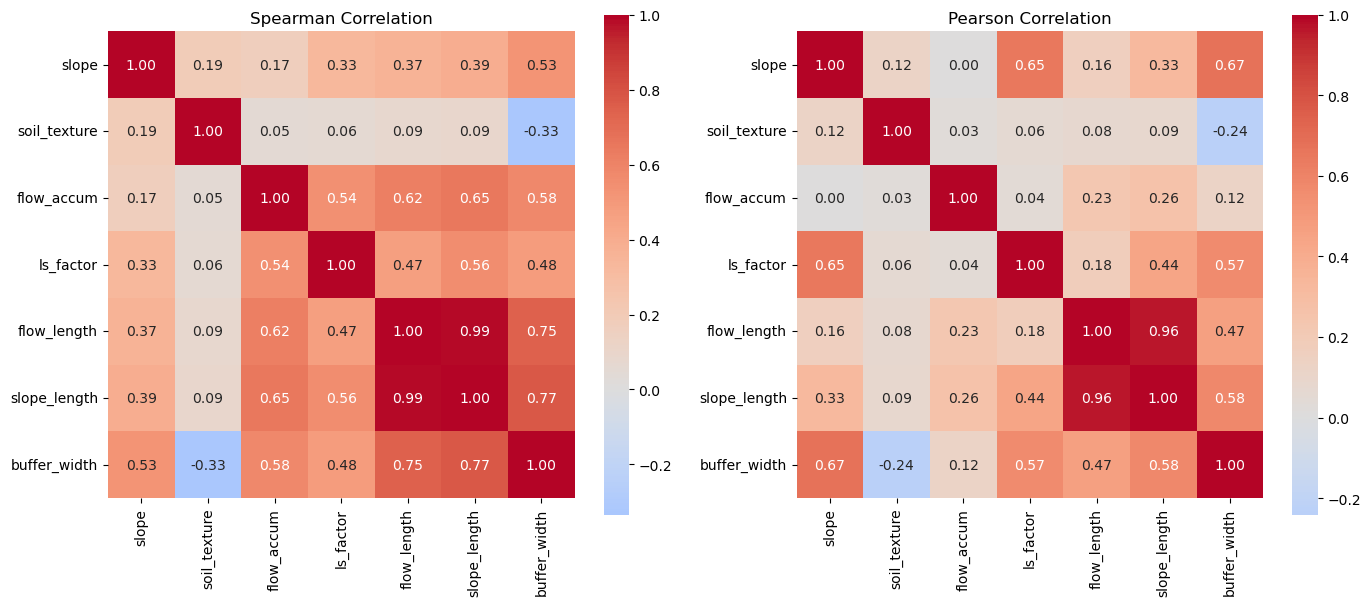

In [5]:
# 2) CORRELATIONS
# Spearman
spearman_corr = final_df_1[variables].corr(method='spearman')
# Pearson: optional (linear, sensitive to non-normality/outliers) #no recommendable in this case
pearson_corr  = final_df_1[variables].corr(method='pearson')

print("\n=== Spearman correlation matrix ===")
print(spearman_corr)
print("\n=== Pearson correlation matrix ===")
print(pearson_corr)

# Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", center=0, square=True, fmt=".2f", ax=axes[0])
axes[0].set_title("Spearman Correlation")
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", center=0, square=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Pearson Correlation")
plt.tight_layout(); plt.show()


=== Spearman correlation matrix ===
                 slope  soil_texture  flow_accum  ls_factor  flow_length  \
slope         1.000000      0.192401    0.166263   0.332799     0.367879   
soil_texture  0.192401      1.000000    0.049306   0.060002     0.085190   
flow_accum    0.166263      0.049306    1.000000   0.544190     0.617818   
ls_factor     0.332799      0.060002    0.544190   1.000000     0.468731   
flow_length   0.367879      0.085190    0.617818   0.468731     1.000000   
slope_length  0.394054      0.088361    0.654873   0.560635     0.987964   
buffer_width  0.529142     -0.334851    0.582793   0.484417     0.748555   

              slope_length  buffer_width  
slope             0.394054      0.529142  
soil_texture      0.088361     -0.334851  
flow_accum        0.654873      0.582793  
ls_factor         0.560635      0.484417  
flow_length       0.987964      0.748555  
slope_length      1.000000      0.770853  
buffer_width      0.770853      1.000000  


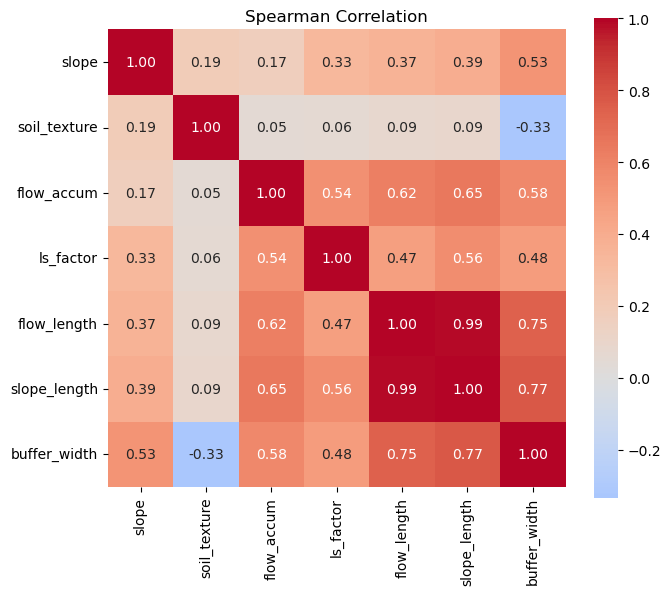

In [6]:
# Spearman
spearman_corr = final_df_1[variables].corr(method='spearman')
print("\n=== Spearman correlation matrix ===")
print(spearman_corr)

fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", center=0, square=True, fmt=".2f", ax=ax)
ax.set_title("Spearman Correlation")
fig.savefig("spearman_heatmap.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()